<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

# Apache Spark Group Project - Earthquake Data - Risk analysis

<a id='0'></a>
## Description
This project has a few objectives:
  
* Build a DataFrame from multiple JSON files.
* Handle some data that's a bit more complex, like arrays of JSON documents.
* Handling variety of data in json and csv format
* Run some simple calculations and analysis on the data.


We'll be diving into an earthquake dataset. The question we want to answer is: ***'In which areas should there be a higher insurance premium (based on the earthquakes frequency and their magnitude)'***

We're going to use **Pandas** to make our results **look much better**. Let's set it up first:

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

**It's time to create the [Spark Session](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.html)** before we can do any other thing. Remember, the Spark Session *is the entry point to programming Spark with the DataFrame API (High-level API)*.

In [2]:
from pyspark.sql.session import SparkSession

spark_session = \
  SparkSession.builder\
              .appName("Earthquake analysis")\
              .getOrCreate()

print(f"This cluster relies on Spark '{spark_session.version}'")

25/12/14 09:37:22 WARN Utils: Your hostname, osbdet resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
25/12/14 09:37:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/14 09:37:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


This cluster relies on Spark '3.5.4'


25/12/14 09:37:35 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


<a id='2'></a>
## Step 1 - Ingest Earthquake data into MinIO
We're going to use a NiFi flow to grab Earthquake data from USGS every 5 minutes. It'll ingest all that info into **the `earthquake`bucket which we created in MinIO**, ready for Spark to analyze later. The data will be in the **[JSON Lines](https://jsonlines.org/)** format Spark knows how to use.

<a id='2.2'></a>
### NiFi flow import

1. **Download** the `Earthquake_info_to_MinIO_(S3).json` attached in the submission
2. **Access** the [Apache NiFi UI](http://localhost:29090/nifi/)
3. **Create a new Process Group** from the JSON file containing the NiFi flow
4. Call it **`Earthquake info to MinIO (S3)`**
5. **Confirm the creation**.
6. Deal with the import warning sign

We're almost there! We need to remove the warning message to be able to move forward; that will be accomplished via **adding the credentials to let NiFi access MinIO**

*Double click the Process Group to access its contents* and configure the **"Controller Services"** (*Right-click the canvas, then click Controller Services*):

Edit the `AWSCredentialsProviderControllerService` Controller Service configure the following two parameters:

- **Access Key ID:** s3access 
- **Secret Access Key:** _s3access123$


<a id='3.1'></a>
### DataFrame creation

We need to tell the Spark Session **how to access MinIO**, our *S3 compatible object store*:

In [3]:
spark_session.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.access.key", "s3access")
spark_session.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "_s3access123$")
spark_session.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
spark_session.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
spark_session.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "http://localhost:9000")

We are now ready to **create the DataFrame on top of the data in MinIO**, which will allow us to *start with the Exploratory Data Analysis*:

In [4]:
from pyspark.sql.functions import input_file_name

earthquake_raw_df = spark_session.read\
                                .json("s3a://earthquake/earthquakes_*.json")

# DataFrame updated with an additional column containing the filename contributing to the data in every row.
earthquake_raw_df = earthquake_raw_df.withColumn("filename_path", input_file_name())

# The inferred schema can be visualized using the printSchema() method - definitely semi-structured data.
earthquake_raw_df.printSchema()

25/12/14 09:37:49 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
25/12/14 09:37:50 WARN VersionInfoUtils: The AWS SDK for Java 1.x entered maintenance mode starting July 31, 2024 and will reach end of support on December 31, 2025. For more information, see https://aws.amazon.com/blogs/developer/the-aws-sdk-for-java-1-x-is-in-maintenance-mode-effective-july-31-2024/
You can print where on the file system the AWS SDK for Java 1.x core runtime is located by setting the AWS_JAVA_V1_PRINT_LOCATION environment variable or aws.java.v1.printLocation system property to 'true'.
This message can be disabled by setting the AWS_JAVA_V1_DISABLE_DEPRECATION_ANNOUNCEMENT environment variable or aws.java.v1.disableDeprecationAnnouncement system property to 'true'.
The AWS SDK for Java 1.x is being used here:
at java.base/java.lang.Thread.getStackTrace(Thread.java:2451)
at com.amazonaws.util.VersionInfoUtils.printDeprecationAn

root
 |-- _corrupt_record: string (nullable = true)
 |-- api: string (nullable = true)
 |-- count: long (nullable = true)
 |-- generated: long (nullable = true)
 |-- geometry: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- properties: struct (nullable = true)
 |    |-- alert: string (nullable = true)
 |    |-- cdi: double (nullable = true)
 |    |-- code: string (nullable = true)
 |    |-- detail: string (nullable = true)
 |    |-- dmin: double (nullable = true)
 |    |-- felt: long (nullable = true)
 |    |-- gap: double (nullable = true)
 |    |-- ids: string (nullable = true)
 |    |-- mag: double (nullable = true)
 |    |-- magType: string (nullable = true)
 |    |-- mmi: double (nullable = true)
 |    |-- net: string (nullable = true)
 |    |-- nst: long (nullable = true)
 |    |-- place: string (nullable = true)
 |    |-- rm

Let's display the ***last 10 files contributing to the DataFrame***:

In [5]:
from  pyspark.sql.functions import col

earthquake_raw_df.select("filename_path")\
                .distinct()\
                .orderBy(col("filename_path").desc())\
                .limit(10)\
                .toPandas()

,filename_path
0,s3a://earthquake/earthquakes_20251213_1439.json
1,s3a://earthquake/earthquakes_20251213_1433.json
2,s3a://earthquake/earthquakes_20251213_1428.json
3,s3a://earthquake/earthquakes_20251213_1423.json
4,s3a://earthquake/earthquakes_20251213_1418.json
5,s3a://earthquake/earthquakes_20251213_1413.json
6,s3a://earthquake/earthquakes_20251213_1408.json
7,s3a://earthquake/earthquakes_20251213_1403.json
8,s3a://earthquake/earthquakes_20251213_1358.json
9,s3a://earthquake/earthquakes_20251213_1353.json


<a id='3.2'></a>
### Shaping the DataFrame to answer business questions

In [6]:
from pyspark.sql.functions import col, from_unixtime

# Select and flatten the key fields we care about
earthquake_df = (
    earthquake_raw_df
    .select(
        col("properties.mag").alias("magnitude"),
        col("properties.time").alias("time_ms"),
        col("properties.place").alias("place"),
        col("geometry.coordinates")[0].alias("longitude"),
        col("geometry.coordinates")[1].alias("latitude"),
        col("geometry.coordinates")[2].alias("depth_km")
    )
    # keep only events with a valid magnitude
    .filter(col("magnitude").isNotNull())
)

# Convert timestamp from milliseconds since epoch to proper timestamp
earthquake_df = earthquake_df.withColumn(
    "event_time",
    from_unixtime(col("time_ms") / 1000)
)

earthquake_df.show(5, truncate=False)


+----------------+-------------+----------------------------------+-----------------+----------------+----------------+-------------------+
|magnitude       |time_ms      |place                             |longitude        |latitude        |depth_km        |event_time         |
+----------------+-------------+----------------------------------+-----------------+----------------+----------------+-------------------+
|1.67            |1765632271050|14 km N of Cloverdale, CA         |-123.024002075195|38.9278335571289|4.32999992370605|2025-12-13 14:24:31|
|1.38750519108927|1765632020690|7 km S of Borrego Springs, CA     |-116.389663696289|33.1936683654785|12.5100002288818|2025-12-13 14:20:20|
|2.1             |1765631536693|46 km E of Pedro Bay, Alaska      |-153.281         |59.836          |141.2           |2025-12-13 14:12:16|
|3.5             |1765631308042|31 km ESE of Susitna North, Alaska|-149.306         |62.049          |4.2             |2025-12-13 14:08:28|
|1.83            |17

<a id='0'></a>
### Explanation of code above
In this step, we transform the raw GeoJSON earthquake data ingested via NiFi into a structured Spark DataFrame suitable for analysis. Since the original dataset contains nested fields, we flatten it by extracting the key attributes needed for our business question—magnitude, timestamp, place, and geographic coordinates (longitude, latitude, depth). We also convert the event time from milliseconds to a readable timestamp and filter out records with missing magnitudes. This reshaped DataFrame provides a clean foundation for calculating earthquake frequency and severity, enabling us to assess regional risk levels and ultimately determine where insurance premiums should be higher.


In [7]:
from pyspark.sql.functions import regexp_extract

earthquake_df = earthquake_df.withColumn(
    "region",
    regexp_extract(col("place"), r",\s*(.*)$", 1)
)

#drop rows where we couldn't find a region
earthquake_df = earthquake_df.filter(col("region") != "")

earthquake_df.select("place", "region").show(10, truncate=False)


+----------------------------------+------+
|place                             |region|
+----------------------------------+------+
|14 km N of Cloverdale, CA         |CA    |
|7 km S of Borrego Springs, CA     |CA    |
|46 km E of Pedro Bay, Alaska      |Alaska|
|31 km ESE of Susitna North, Alaska|Alaska|
|17 km W of Volcano, Hawaii        |Hawaii|
|55 km NW of Toyah, Texas          |Texas |
|12 km N of Four Mile Road, Alaska |Alaska|
|14 km NE of Pedro Bay, Alaska     |Alaska|
|3 km SW of Borrego Springs, CA    |CA    |
|99 km N of Yakutat, Alaska        |Alaska|
+----------------------------------+------+
only showing top 10 rows



<a id='0'></a>
### Explanation of code above
Each earthquake record includes a textual description of its location in the place field, typically ending with a region such as a state or country (e.g., “3 km SSW of Cobb, CA”). To make this information usable for aggregation, we extract the region by capturing the text after the final comma using a regular expression. We then remove any rows where a region could not be identified. This gives us a clean region column that allows us to group earthquakes geographically and later compute risk scores for insurance analysis.


In [8]:
from pyspark.sql.functions import pow

earthquake_df = earthquake_df.withColumn(
    "mag_score",
    pow(col("magnitude"), 2)
)

earthquake_df.select("magnitude", "mag_score", "region").show(5, truncate=False)


+----------------+------------------+------+
|magnitude       |mag_score         |region|
+----------------+------------------+------+
|1.67            |2.7889            |CA    |
|1.38750519108927|1.9251706552996715|CA    |
|2.1             |4.41              |Alaska|
|3.5             |12.25             |Alaska|
|1.83            |3.3489000000000004|Hawaii|
+----------------+------------------+------+
only showing top 5 rows



<a id='0'></a>
### Explanation of code above
To quantify the impact of each earthquake, we create a new mag_score column by squaring the event's magnitude. Since the magnitude scale is logarithmic, this transformation increases the influence of stronger earthquakes and provides a more realistic measure of severity for risk assessment. This severity score will later be aggregated by region to help identify areas where insurance premiums should be higher due to more intense seismic activity.


In [9]:
from pyspark.sql.functions import count, sum as sum_

risk_raw_df = (
    earthquake_df
    .groupBy("region")
    .agg(
        count("*").alias("quake_count"),
        sum_("mag_score").alias("severity_score")
    )
)

risk_raw_df.orderBy(col("quake_count").desc()).show(10, truncate=False)


+-----------+-----------+------------------+
|region     |quake_count|severity_score    |
+-----------+-----------+------------------+
|CA         |837        |1281.5827435663227|
|Alaska     |516        |3134.5499999999993|
|Texas      |149        |324.1100000000001 |
|New Mexico |102        |481.73            |
|Puerto Rico|82         |591.7399          |
|Hawaii     |45         |166.4318          |
|Utah       |39         |87.60179999999997 |
|Washington |35         |44.423399999999994|
|Philippines|26         |562.77            |
|Fiji       |26         |538.8500000000001 |
+-----------+-----------+------------------+
only showing top 10 rows



<a id='0'></a>
### Explanation of code above
To compare earthquake risk across different regions, we aggregate the dataset by the region column and compute two key metrics: the total number of earthquakes (quake_count) and the cumulative severity (severity_score), which is the sum of squared magnitudes. These metrics capture both how frequently earthquakes occur and how powerful they are in each area. This aggregated view forms the quantitative foundation for identifying high-risk regions where insurance premiums should be set higher.


In [10]:
from pyspark.sql.functions import max as max_

max_vals = risk_raw_df.agg(
    max_("quake_count").alias("max_count"),
    max_("severity_score").alias("max_severity")
).collect()[0]

max_count = max_vals["max_count"]
max_severity = max_vals["max_severity"]

risk_df = (
    risk_raw_df
    .withColumn(
        "risk_index",
        (col("quake_count") / max_count) * 0.4 +
        (col("severity_score") / max_severity) * 0.6
    )
)

# Regions with highest suggested insurance premiums:
risk_df.orderBy(col("risk_index").desc()).show(20, truncate=False)


+------------------------+-----------+------------------+--------------------+
|region                  |quake_count|severity_score    |risk_index          |
+------------------------+-----------+------------------+--------------------+
|Alaska                  |516        |3134.5499999999993|0.8465949820788531  |
|CA                      |837        |1281.5827435663227|0.6453142065495187  |
|Puerto Rico             |82         |591.7399          |0.15245548872609468 |
|New Mexico              |102        |481.73            |0.14095588483744217 |
|Japan                   |26         |640.2499999999999 |0.13497880512994584 |
|Texas                   |149        |324.1100000000001 |0.13324621776639126 |
|Philippines             |26         |562.77            |0.12014796816770246 |
|Fiji                    |26         |538.8500000000001 |0.11556932051492935 |
|Aleutian Islands, Alaska|13         |393.25            |0.08148662704695599 |
|Chile                   |13         |379.0800000000

<a id='0'></a>
### Explanation of code above
To identify regions where insurance premiums should be higher, we normalize and combine two key indicators: earthquake frequency (quake_count) and cumulative severity (severity_score). Each metric is scaled relative to its maximum value across all regions, ensuring they contribute proportionally. We weight severity more heavily (60%) since stronger earthquakes have a greater financial impact than frequent minor ones. The resulting risk_index provides a single, comparable measure of seismic risk, allowing us to rank regions from highest to lowest insurance priority.


In [11]:
top_risk_pd = (
    risk_df
    .orderBy(col("risk_index").desc())
    .limit(20)
    .toPandas()
)

top_risk_pd


,region,quake_count,severity_score,risk_index
0,Alaska,516,3134.550000,0.846595
1,CA,837,1281.582744,0.645314
2,Puerto Rico,82,591.739900,0.152455
3,New Mexico,102,481.730000,0.140956
4,Japan,26,640.250000,0.134979
5,Texas,149,324.110000,0.133246
6,Philippines,26,562.770000,0.120148
7,Fiji,26,538.850000,0.115569
8,"Aleutian Islands, Alaska",13,393.250000,0.081487
9,Chile,13,379.080000,0.078774


<a id='0'></a>
### Explanation of code above
To highlight the areas that face the greatest seismic threat, we convert the aggregated Spark DataFrame into a Pandas table and display the top 20 regions ranked by our combined risk_index. This ranking reflects both how often earthquakes occur and how severe they are in each location. Regions such as Alaska and California appear at the top of the list, indicating consistently high levels of seismic activity. These results provide clear evidence for where insurance companies should consider applying higher premiums due to elevated earthquake risk.


<a id='0'></a>
## All of the code below reproduces what was done above however it now deals with variety, so it now takes both json files as well as csv files


In [6]:
from pyspark.sql.functions import col, from_unixtime

# Read JSON Lines produced by NiFi (one earthquake per line)
json_raw_df = spark_session.read.json("s3a://earthquake/earthquakes_*.json")

# json_raw_df.printSchema()  # optional: to verify columns

json_flat_df = (
    json_raw_df
    .select(
        col("properties.mag").alias("magnitude"),
        col("properties.time").alias("time_ms"),
        col("properties.place").alias("place"),
        col("geometry.coordinates")[0].alias("longitude"),
        col("geometry.coordinates")[1].alias("latitude"),
        col("geometry.coordinates")[2].alias("depth_km")
    )
    .filter(col("magnitude").isNotNull())
    .withColumn("event_time", from_unixtime(col("time_ms")/1000))
)


In [7]:
from pyspark.sql.functions import to_timestamp

csv_raw_df = (
    spark_session.read
        .option("header", "true")
        .option("inferSchema", "true")
        .csv("s3a://earthquake/earthquakes_*.csv")
)

csv_flat_df = (
    csv_raw_df
    .select(
        col("mag").alias("magnitude"),
        col("time").alias("time_str"),
        col("place"),
        col("longitude"),
        col("latitude"),
        col("depth").alias("depth_km")
    )
    .filter(col("magnitude").isNotNull())
    .withColumn("event_time", to_timestamp(col("time_str")))
)


In [8]:
common_columns = [
    "magnitude", "place", "longitude", "latitude", "depth_km", "event_time"
]

json_df_std = json_flat_df.select(common_columns)
csv_df_std = csv_flat_df.select(common_columns)


In [9]:
earthquake_all_df = json_df_std.unionByName(csv_df_std)


In [10]:
from pyspark.sql.functions import regexp_extract

earthquake_all_df = earthquake_all_df.withColumn(
    "region",
    regexp_extract(col("place"), r",\s*(.*)$", 1)
).filter(col("region") != "")


In [11]:
from pyspark.sql.functions import pow

earthquake_all_df = earthquake_all_df.withColumn(
    "mag_score",
    pow(col("magnitude"), 2)
)


In [12]:
from pyspark.sql.functions import count, sum as sum_, max as max_

risk_raw_df = (
    earthquake_all_df
    .groupBy("region")
    .agg(
        count("*").alias("quake_count"),
        sum_("mag_score").alias("severity_score")
    )
)


In [13]:
max_vals = risk_raw_df.agg(
    max_("quake_count").alias("max_count"),
    max_("severity_score").alias("max_severity")
).collect()[0]

risk_df = (
    risk_raw_df
    .withColumn(
        "risk_index",
        (col("quake_count") / max_vals["max_count"]) * 0.4 +
        (col("severity_score") / max_vals["max_severity"]) * 0.6
    )
)

risk_df.orderBy(col("risk_index").desc()).show(20, truncate=False)


+------------------------+-----------+------------------+--------------------+
|region                  |quake_count|severity_score    |risk_index          |
+------------------------+-----------+------------------+--------------------+
|Alaska                  |709        |4364.169999999999 |0.8498678414096916  |
|CA                      |1135       |1741.28365805397  |0.6393972266965728  |
|Puerto Rico             |112        |780.8173          |0.14682061646996697 |
|Texas                   |214        |464.1100000000001 |0.139225824098903   |
|New Mexico              |134        |644.18            |0.13578858897421786 |
|Japan                   |36         |886.4999999999999 |0.1345660699024886  |
|Fiji                    |38         |783.0800000000002 |0.12105240452289812 |
|Philippines             |36         |779.22            |0.11981687360628566 |
|Aleutian Islands, Alaska|18         |544.5             |0.08120320763012713 |
|Chile                   |18         |524.8800000000

<a id='0'></a>
# Appendix
In the Appendix we will include the code we used in order to generate plots from our data in order to include in our slides for the presentation.


In [20]:
pip install plotly


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<a id='0'></a>
# The code below generates an interactive map of the entire world and it shows a heat area of the earthquakes location and their severity


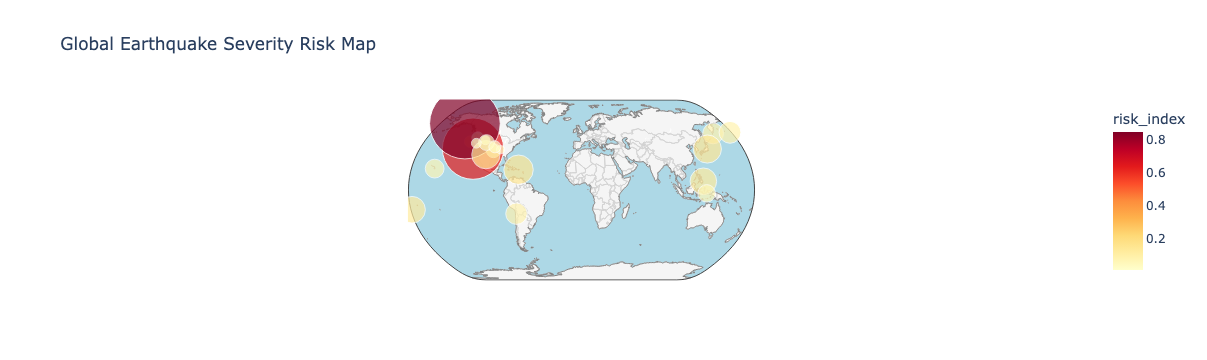

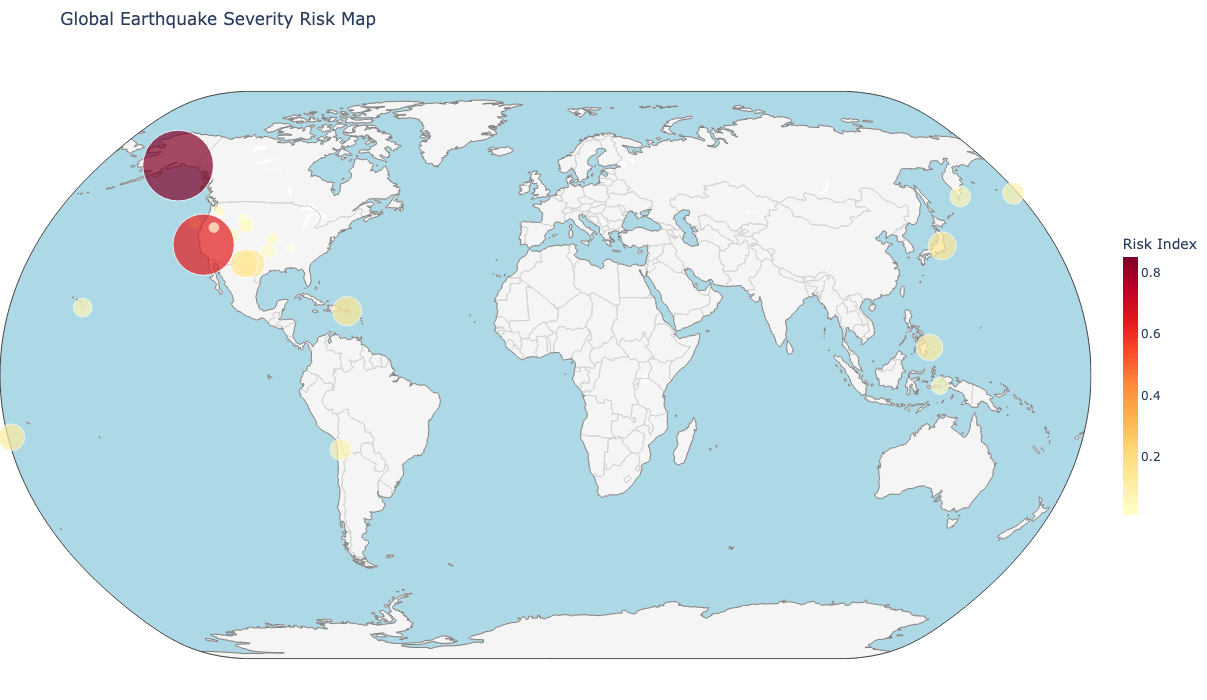

Map saved as 'earthquake_risk_map.html'


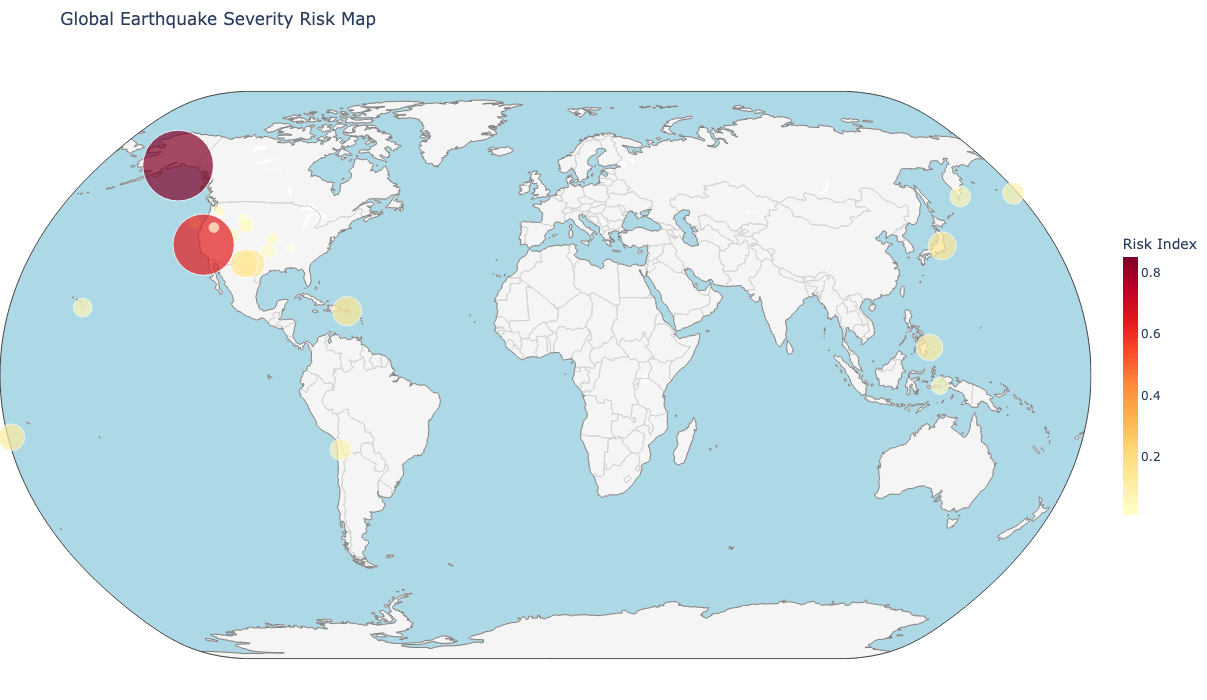

In [21]:
import plotly.express as px
import pandas as pd
from pyspark.sql.functions import col, avg as avg_

# Collect the risk data to pandas for visualization
risk_pandas_df = risk_df.toPandas()

# Get average coordinates for each region from the original data
region_coords_df = (
    earthquake_all_df
    .groupBy("region")
    .agg(
        avg_("latitude").alias("avg_latitude"),
        avg_("longitude").alias("avg_longitude")
    )
)

# Join risk data with coordinates
map_data_df = risk_df.join(region_coords_df, on="region", how="inner")

# Convert to pandas for plotting
map_pandas_df = map_data_df.toPandas()

# Create the map with plotly
fig = px.scatter_geo(
    map_pandas_df,
    lat="avg_latitude",
    lon="avg_longitude",
    size="risk_index",  # Bubble size based on risk
    color="risk_index",  # Color intensity based on risk
    hover_name="region",
    hover_data={
        "quake_count": True,
        "severity_score": ":.2f",
        "risk_index": ":.3f",
        "avg_latitude": ":.2f",
        "avg_longitude": ":.2f"
    },
    color_continuous_scale="YlOrRd",  # Yellow to Red color scale
    size_max=50,
    title="Global Earthquake Severity Risk Map",
    projection="natural earth"
)

# Customize the map appearance
fig.update_geos(
    showcountries=True,
    countrycolor="lightgray",
    showcoastlines=True,
    coastlinecolor="gray",
    showland=True,
    landcolor="whitesmoke",
    showocean=True,
    oceancolor="lightblue"
)

fig.update_layout(
    height=700,
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    coloraxis_colorbar=dict(
        title="Risk Index",
        thicknessmode="pixels",
        thickness=15,
        lenmode="pixels",
        len=300
    )
)

# Save the map as an HTML file
fig.write_html("earthquake_risk_map.html")
print("Map saved as 'earthquake_risk_map.html'")

# Display the map (if running in Jupyter/interactive environment)
fig.show()



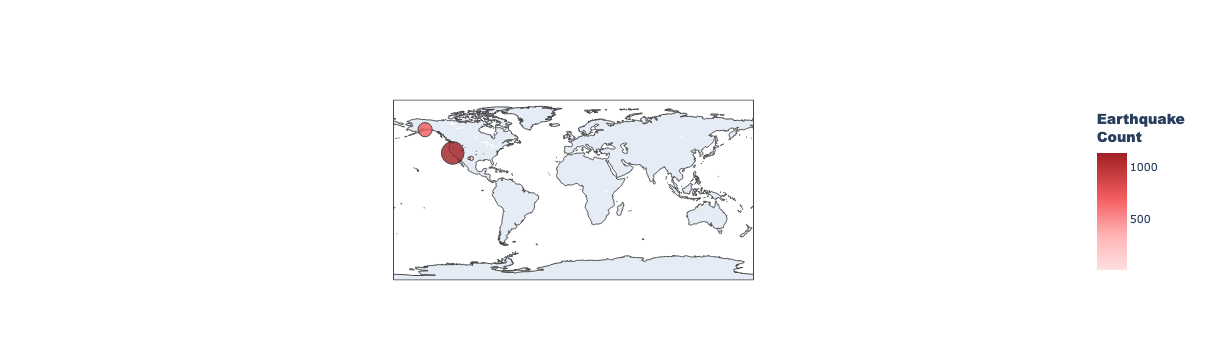

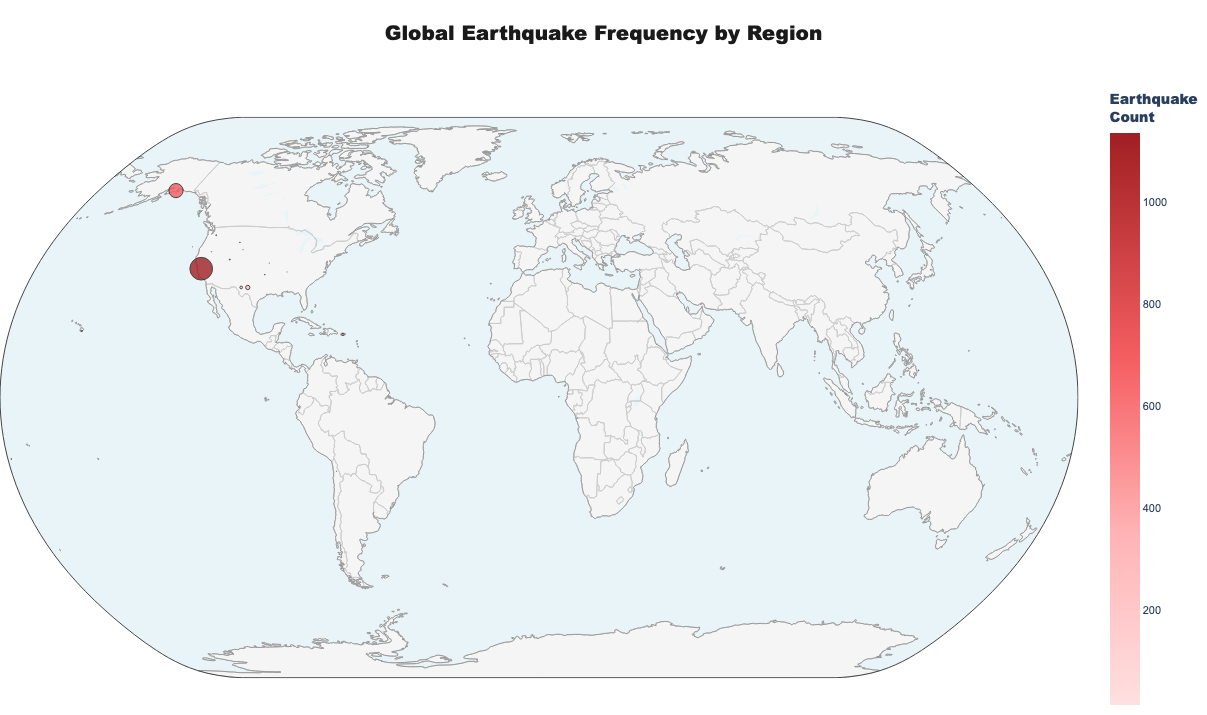

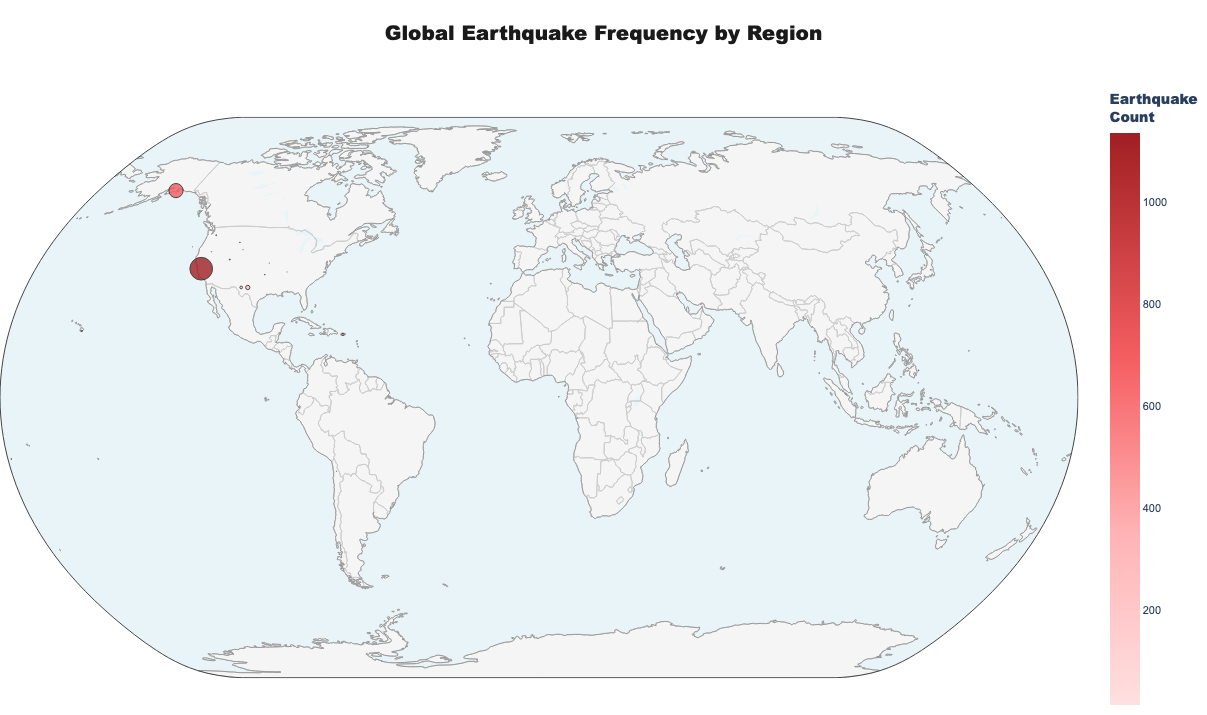

✓ Map 1 saved: earthquake_frequency_map.html


In [23]:
# ============================================
# MAP 1: Earthquake Frequency World Map
# ============================================
import plotly.graph_objects as go
from pyspark.sql.functions import avg as avg_

# Get average coordinates for each region from the original data
region_coords_df = (
    earthquake_all_df
    .groupBy("region")
    .agg(
        avg_("latitude").alias("avg_latitude"),
        avg_("longitude").alias("avg_longitude")
    )
)

# Join risk data with coordinates
map_data_df = risk_df.join(region_coords_df, on="region", how="inner")

# Convert to pandas for plotting
map_data = map_data_df.toPandas()

# Define presentation colors
COLOR_PRIMARY = '#F65F62'  # Coral red

fig1 = go.Figure()

# Add scatter geo for earthquake frequency
fig1.add_trace(go.Scattergeo(
    lon=map_data['avg_longitude'],
    lat=map_data['avg_latitude'],
    text=map_data['region'],
    mode='markers',
    marker=dict(
        size=map_data['quake_count'] / 50,  # Scale marker size
        color=map_data['quake_count'],
        colorscale=[
            [0, '#FFE0E0'],
            [0.3, '#FFB3B5'],
            [0.6, COLOR_PRIMARY],
            [1.0, '#A01F22']
        ],
        colorbar=dict(
            title=dict(text="Earthquake<br>Count", font=dict(size=14, family='Arial Black')),
            tickfont=dict(size=11)
        ),
        line=dict(width=1, color='#1a1a1a'),
        sizemode='diameter',
        opacity=0.8
    ),
    customdata=map_data[['quake_count', 'severity_score', 'risk_index']],
    hovertemplate=
        '<b>%{text}</b><br>' +
        'Earthquake Count: %{customdata[0]:,.0f}<br>' +
        'Severity Score: %{customdata[1]:,.1f}<br>' +
        'Risk Index: %{customdata[2]:.3f}<br>' +
        '<extra></extra>'
))

fig1.update_layout(
    title=dict(
        text='<b>Global Earthquake Frequency by Region</b>',
        font=dict(size=20, family='Arial Black', color='#1a1a1a'),
        x=0.5,
        xanchor='center'
    ),
    geo=dict(
        projection_type='natural earth',
        showland=True,
        landcolor='#F5F5F5',
        showocean=True,
        oceancolor='#E8F4F8',
        showcountries=True,
        countrycolor='#CCCCCC',
        showlakes=True,
        lakecolor='#E8F4F8',
        coastlinecolor='#999999',
    ),
    width=1400,
    height=700,
    paper_bgcolor='white',
    font=dict(family='Arial', size=12),
    margin=dict(l=0, r=0, t=80, b=0)
)

fig1.write_html('earthquake_frequency_map.html')
fig1.show()
print("✓ Map 1 saved: earthquake_frequency_map.html")

<Figure size 1200x700 with 0 Axes>

[Text(0, 0, 'Alaska'),
 Text(0, 1, 'CA'),
 Text(0, 2, 'Puerto Rico'),
 Text(0, 3, 'Texas'),
 Text(0, 4, 'New Mexico'),
 Text(0, 5, 'Japan'),
 Text(0, 6, 'Fiji'),
 Text(0, 7, 'Philippines'),
 Text(0, 8, 'Aleutian Islands, Alaska'),
 Text(0, 9, 'Chile')]

Text(0.5, 0, 'Risk Index')

Text(0.5, 1.0, 'Earthquake Risk Index by Region')

Text(0.8598678414096916, 0.0, '0.850')

Text(0.6493972266965728, 1.0, '0.639')

Text(0.15682061646996698, 2.0, '0.147')

Text(0.149225824098903, 3.0, '0.139')

Text(0.14578858897421787, 4.0, '0.136')

Text(0.1445660699024886, 5.0, '0.135')

Text(0.13105240452289812, 6.0, '0.121')

Text(0.12981687360628566, 7.0, '0.120')

Text(0.09120320763012713, 8.0, '0.081')

Text(0.08850578750213028, 9.0, '0.079')

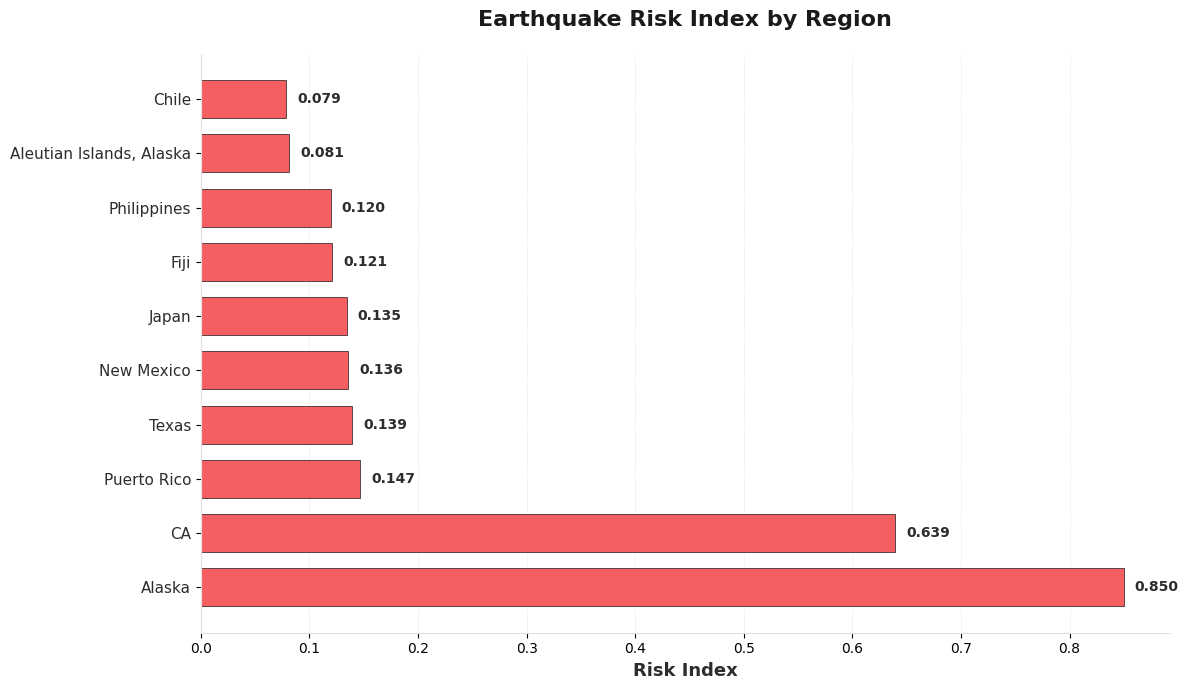

In [19]:
# ============================================
# VISUALIZATION 1: Risk Index by Region (Horizontal Bar Chart)
# ============================================

from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np

# Get top 10 regions by risk index
top10_risk = (
    risk_df
    .orderBy(col("risk_index").desc())
    .limit(10)
    .toPandas()
)

# Presentation colors from your slides
COLOR_PRIMARY = '#F65F62'  # Coral red
COLOR_SECONDARY = '#E5E0DF'  # Light taupe
COLOR_DARK = '#1a1a1a'  # Dark background
COLOR_TEXT = '#2d2d2d'  # Dark text

# Create figure
plt.figure(figsize=(12, 7), facecolor='white')
ax = plt.gca()

# Create horizontal bar chart
y_pos = np.arange(len(top10_risk))
bars = ax.barh(y_pos, top10_risk['risk_index'], 
               color=COLOR_PRIMARY, 
               edgecolor=COLOR_DARK, 
               linewidth=0.5,
               height=0.7)

# Customize axes
ax.set_yticks(y_pos)
ax.set_yticklabels(top10_risk['region'], fontsize=11, color=COLOR_TEXT)
ax.set_xlabel('Risk Index', fontsize=13, color=COLOR_TEXT, fontweight='bold')
ax.set_title('Earthquake Risk Index by Region', 
             fontsize=16, 
             fontweight='bold', 
             color=COLOR_DARK,
             pad=20)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top10_risk['risk_index'])):
    ax.text(value + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{value:.3f}', 
            va='center', 
            fontsize=10, 
            color=COLOR_TEXT,
            fontweight='bold')

# Style the plot
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLOR_SECONDARY)
ax.spines['bottom'].set_color(COLOR_SECONDARY)
ax.grid(axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('risk_index_by_region.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Text(10, 10, 'Alaska')

Text(10, 10, 'CA')

Text(10, 10, 'Puerto Rico')

Text(10, 10, 'Texas')

Text(10, 10, 'New Mexico')

Text(0.5, 0, 'Earthquake Frequency (Normalized)')

Text(0, 0.5, 'Destructive Potential (Normalized)')

Text(0.5, 1.0, 'Earthquake Frequency vs. Destructive Potential by Region')

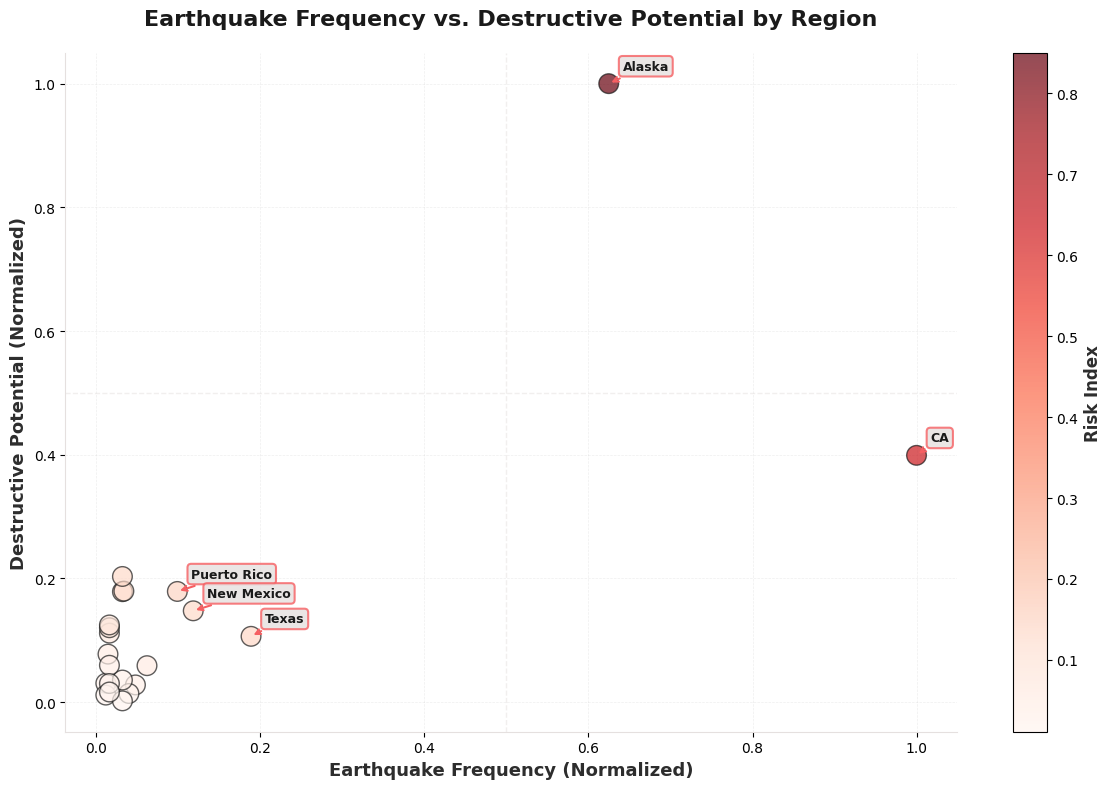

In [20]:
# ============================================
# VISUALIZATION 2: Frequency vs. Destructive Potential (Scatter Plot)
# ============================================

import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Get all regions data
all_regions = risk_df.toPandas()

# Normalize values for better visualization
max_count = all_regions['quake_count'].max()
max_severity = all_regions['severity_score'].max()

all_regions['freq_normalized'] = all_regions['quake_count'] / max_count
all_regions['severity_normalized'] = all_regions['severity_score'] / max_severity

# Create color mapping based on risk_index
colors = all_regions['risk_index'].values

# Create figure
fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')

# Create scatter plot
scatter = ax.scatter(all_regions['freq_normalized'], 
                     all_regions['severity_normalized'],
                     c=colors,
                     s=200,
                     alpha=0.7,
                     cmap='Reds',
                     edgecolors=COLOR_DARK,
                     linewidth=1)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Risk Index', fontsize=12, fontweight='bold', color=COLOR_TEXT)
cbar.ax.tick_params(labelsize=10)

# Label top 5 regions
top5 = all_regions.nlargest(5, 'risk_index')
for idx, row in top5.iterrows():
    ax.annotate(row['region'], 
                xy=(row['freq_normalized'], row['severity_normalized']),
                xytext=(10, 10), 
                textcoords='offset points',
                fontsize=9,
                color=COLOR_DARK,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', 
                         facecolor=COLOR_SECONDARY, 
                         edgecolor=COLOR_PRIMARY,
                         linewidth=1.5,
                         alpha=0.8),
                arrowprops=dict(arrowstyle='->', 
                               connectionstyle='arc3,rad=0',
                               color=COLOR_PRIMARY,
                               linewidth=1.5))

# Customize plot
ax.set_xlabel('Earthquake Frequency (Normalized)', fontsize=13, fontweight='bold', color=COLOR_TEXT)
ax.set_ylabel('Destructive Potential (Normalized)', fontsize=13, fontweight='bold', color=COLOR_TEXT)
ax.set_title('Earthquake Frequency vs. Destructive Potential by Region',
             fontsize=16, fontweight='bold', color=COLOR_DARK, pad=20)

# Add quadrant lines
ax.axhline(y=0.5, color=COLOR_SECONDARY, linestyle='--', linewidth=1, alpha=0.5)
ax.axvline(x=0.5, color=COLOR_SECONDARY, linestyle='--', linewidth=1, alpha=0.5)

# Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLOR_SECONDARY)
ax.spines['bottom'].set_color(COLOR_SECONDARY)
ax.grid(alpha=0.2, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('frequency_vs_potential.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

Text(0, 0.12493392070484582, '0.250')

Text(0, 0.5498678414096916, '0.600')

Text(0, 0.8698678414096916, '0.850')

Text(1, 0.2, '0.400')

Text(1, 0.5196986133482864, '0.239')

Text(1, 0.6593972266965729, '0.639')

Text(2, 0.01973568281938326, '0.039')

Text(2, 0.09314599105436674, '0.107')

Text(2, 0.16682061646996696, '0.147')

Text(3, 0.03770925110132159, '0.075')

Text(3, 0.10732216315077309, '0.064')

Text(3, 0.15922582409890298, '0.139')

Text(4, 0.023612334801762114, '0.047')

Text(4, 0.09150662928887104, '0.089')

Text(4, 0.15578858897421785, '0.136')

Text(0, 0.5, 'Risk Index Value')

Text(0.5, 0, 'Region')

Text(0.5, 1.0, 'Risk Index Composition: Frequency vs. Severity\n(Top 5 Highest Risk Regions)')

[Text(0, 0, 'Alaska'),
 Text(1, 0, 'CA'),
 Text(2, 0, 'Puerto Rico'),
 Text(3, 0, 'Texas'),
 Text(4, 0, 'New Mexico')]

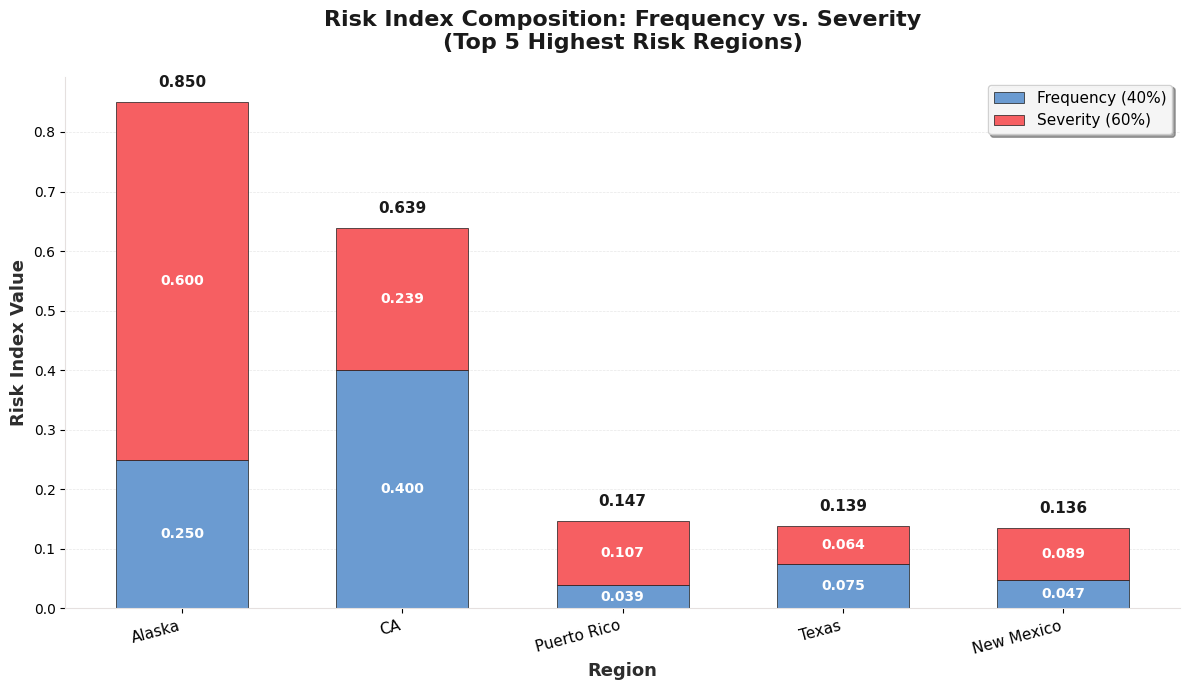

In [22]:
# ============================================
# VISUALIZATION 3: Risk Index Composition (Stacked Bar Chart)
# ============================================

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col

# Get top 5 regions
top5_regions = (
    risk_df
    .orderBy(col("risk_index").desc())
    .limit(5)
    .toPandas()
)

# Calculate the contribution of frequency and severity to the risk index
# Risk Index = (quake_count/max_count)*0.4 + (severity_score/max_severity)*0.6
max_count = risk_df.agg({"quake_count": "max"}).collect()[0][0]
max_severity = risk_df.agg({"severity_score": "max"}).collect()[0][0]

top5_regions['freq_contribution'] = (top5_regions['quake_count'] / max_count) * 0.4
top5_regions['severity_contribution'] = (top5_regions['severity_score'] / max_severity) * 0.6

# Create figure
fig, ax = plt.subplots(figsize=(12, 7), facecolor='white')

# Create stacked bar chart
x = np.arange(len(top5_regions))
width = 0.6

# Colors for the two components
color_freq = '#6B9BD1'  # Blue for frequency
color_severity = COLOR_PRIMARY  # Red for severity

bar1 = ax.bar(x, top5_regions['freq_contribution'], width, 
              label='Frequency (40%)', color=color_freq, 
              edgecolor=COLOR_DARK, linewidth=0.5)
bar2 = ax.bar(x, top5_regions['severity_contribution'], width,
              bottom=top5_regions['freq_contribution'],
              label='Severity (60%)', color=color_severity,
              edgecolor=COLOR_DARK, linewidth=0.5)

# Add value labels
for i, (freq, sev) in enumerate(zip(top5_regions['freq_contribution'], 
                                     top5_regions['severity_contribution'])):
    # Frequency label
    ax.text(i, freq/2, f'{freq:.3f}', 
            ha='center', va='center', 
            fontsize=10, fontweight='bold', 
            color='white')
    # Severity label
    ax.text(i, freq + sev/2, f'{sev:.3f}', 
            ha='center', va='center', 
            fontsize=10, fontweight='bold', 
            color='white')
    # Total label
    ax.text(i, freq + sev + 0.02, f'{freq+sev:.3f}', 
            ha='center', va='bottom', 
            fontsize=11, fontweight='bold', 
            color=COLOR_DARK)

# Customize plot
ax.set_ylabel('Risk Index Value', fontsize=13, fontweight='bold', color=COLOR_TEXT)
ax.set_xlabel('Region', fontsize=13, fontweight='bold', color=COLOR_TEXT)
ax.set_title('Risk Index Composition: Frequency vs. Severity\n(Top 5 Highest Risk Regions)',
             fontsize=16, fontweight='bold', color=COLOR_DARK, pad=20)
ax.set_xticks(x)
ax.set_xticklabels(top5_regions['region'], rotation=15, ha='right', fontsize=11)
ax.legend(loc='upper right', fontsize=11, frameon=True, 
          fancybox=True, shadow=True, framealpha=0.9)

# Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color(COLOR_SECONDARY)
ax.spines['bottom'].set_color(COLOR_SECONDARY)
ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('risk_composition.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

/tmp/ipykernel_1427/2961776220.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


Text(1, 27.928571428571427, 'μ=27.93')

Text(2, 95.0, 'μ=95.00')

Text(3, 922.0, 'μ=922.00')

Text(0, 0.5, 'Earthquake Frequency per Region (log scale)')

Text(0.5, 0, 'Risk Tier')

Text(0.5, 1.0, 'Earthquake Frequency Distribution by Risk Tier')

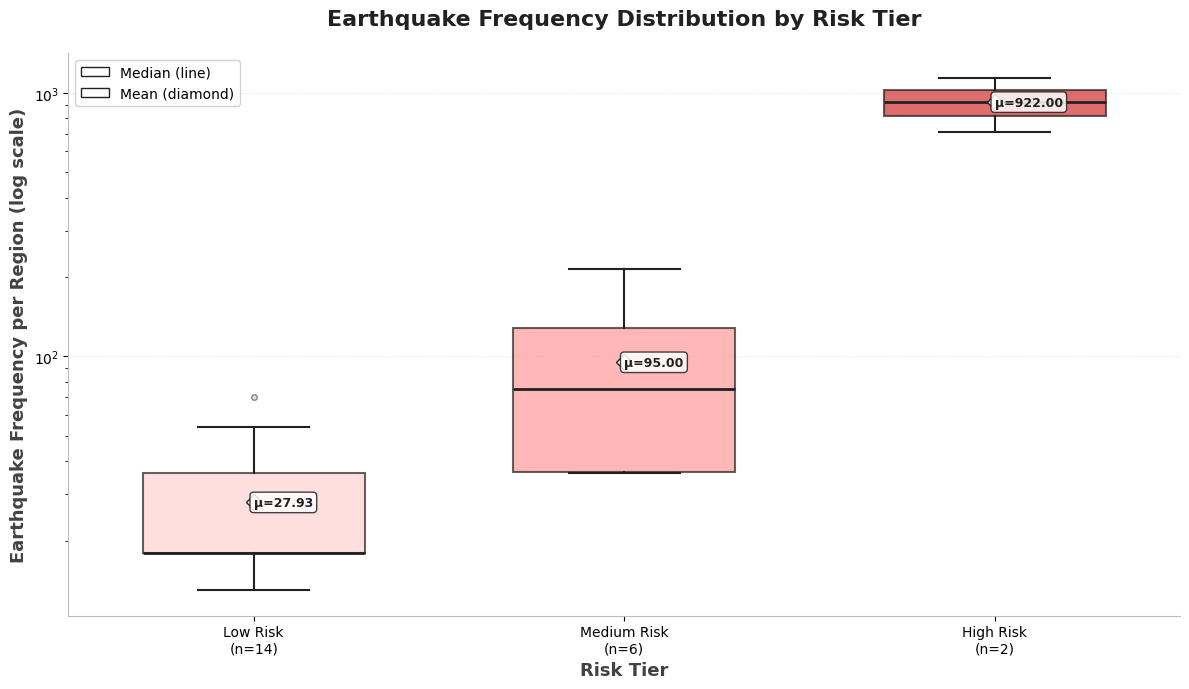

In [52]:
# ============================================
# VISUALIZATION: Earthquake Frequency by Risk Tier (Box Plot)
# ============================================

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col, when

# -------------------------------------------------------------------
# 1. Define colors (adjust if you already have your own palette)
# -------------------------------------------------------------------
COLOR_PRIMARY   = '#D32F2F'
COLOR_SECONDARY = '#BDBDBD'
COLOR_DARK      = '#212121'
COLOR_TEXT      = '#424242'

# -------------------------------------------------------------------
# 2. Add risk tiers to risk_df (region-level dataframe)
#    risk_df has: region, quake_count, severity_score, risk_index
# -------------------------------------------------------------------
risk_with_tiers = (
    risk_df
    .withColumn(
        "risk_tier",
        when(col("risk_index") >= 0.6, "High Risk")
        .when(col("risk_index") >= 0.1, "Medium Risk")
        .otherwise("Low Risk")
    )
)

# -------------------------------------------------------------------
# 3. Convert to Pandas and prepare data for boxplot
# -------------------------------------------------------------------
metric_col = "quake_count"  # what we plot on the y-axis

metric_by_tier = (
    risk_with_tiers
    .select("risk_tier", metric_col)
    .toPandas()
)

risk_order = ["Low Risk", "Medium Risk", "High Risk"]

data_by_tier = [
    metric_by_tier[metric_by_tier["risk_tier"] == tier][metric_col].values
    for tier in risk_order
]

# Add sample size (n) to labels so it's clear why High Risk is a line
labels_with_n = [
    f"{tier}\n(n={len(d)})" for tier, d in zip(risk_order, data_by_tier)
]

# -------------------------------------------------------------------
# 4. Create the boxplot
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 7), facecolor="white")

box_colors = ["#FFD1D1", "#FF9999", COLOR_PRIMARY]

bp = ax.boxplot(
    data_by_tier,
    labels=labels_with_n,
    patch_artist=True,
    widths=0.6,
    showmeans=True,
    meanprops=dict(
        marker='D',
        markerfacecolor='white',
        markeredgecolor=COLOR_DARK,
        markersize=8
    ),
    medianprops=dict(color=COLOR_DARK, linewidth=2),
    boxprops=dict(linewidth=1.5, edgecolor=COLOR_DARK),
    whiskerprops=dict(linewidth=1.5, color=COLOR_DARK),
    capprops=dict(linewidth=1.5, color=COLOR_DARK),
    flierprops=dict(
        marker='o',
        markerfacecolor=COLOR_SECONDARY,
        markersize=4,
        alpha=0.5,
        markeredgecolor=COLOR_DARK
    )
)

# Color the boxes
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# -------------------------------------------------------------------
# 5. Add mean value annotations
# -------------------------------------------------------------------
for i, data in enumerate(data_by_tier):
    if len(data) > 0:
        mean = np.mean(data)
        ax.text(
            i + 1, mean, f"μ={mean:.2f}",
            ha="left",
            va="center",
            fontsize=9,
            color=COLOR_DARK,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=COLOR_DARK,
                alpha=0.85
            )
        )

# -------------------------------------------------------------------
# 6. Styling, log scale, labels, legend
# -------------------------------------------------------------------
ax.set_yscale("log")  # makes all tiers visible despite different scales

ax.set_ylabel(
    "Earthquake Frequency per Region (log scale)",
    fontsize=13,
    fontweight="bold",
    color=COLOR_TEXT
)
ax.set_xlabel(
    "Risk Tier",
    fontsize=13,
    fontweight="bold",
    color=COLOR_TEXT
)
ax.set_title(
    "Earthquake Frequency Distribution by Risk Tier",
    fontsize=16,
    fontweight="bold",
    color=COLOR_DARK,
    pad=20
)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="white", edgecolor=COLOR_DARK, label="Median (line)"),
    Patch(facecolor="white", edgecolor=COLOR_DARK, label="Mean (diamond)")
]
ax.legend(
    handles=legend_elements,
    loc="upper left",
    fontsize=10,
    framealpha=0.9
)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(COLOR_SECONDARY)
ax.spines["bottom"].set_color(COLOR_SECONDARY)
ax.grid(axis="y", alpha=0.3, linestyle="--", linewidth=0.5)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig(
    "frequency_by_risk_tier_pretty.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)
plt.show()


<Axes: >

[Text(0.5, 0, 'Earthquake\nFrequency'),
 Text(1.5, 0, 'Severity\nScore'),
 Text(2.5, 0, 'Risk\nIndex')]

[Text(0, 0.5, 'Earthquake\nFrequency'),
 Text(0, 1.5, 'Severity\nScore'),
 Text(0, 2.5, 'Risk\nIndex')]

Text(0.5, 1.0, 'Correlation Matrix: Risk Metrics Analysis')

Text(0.5, 0.02, 'Strong positive correlations indicate metrics move together\n(Higher frequency → Higher severity → Higher risk)')

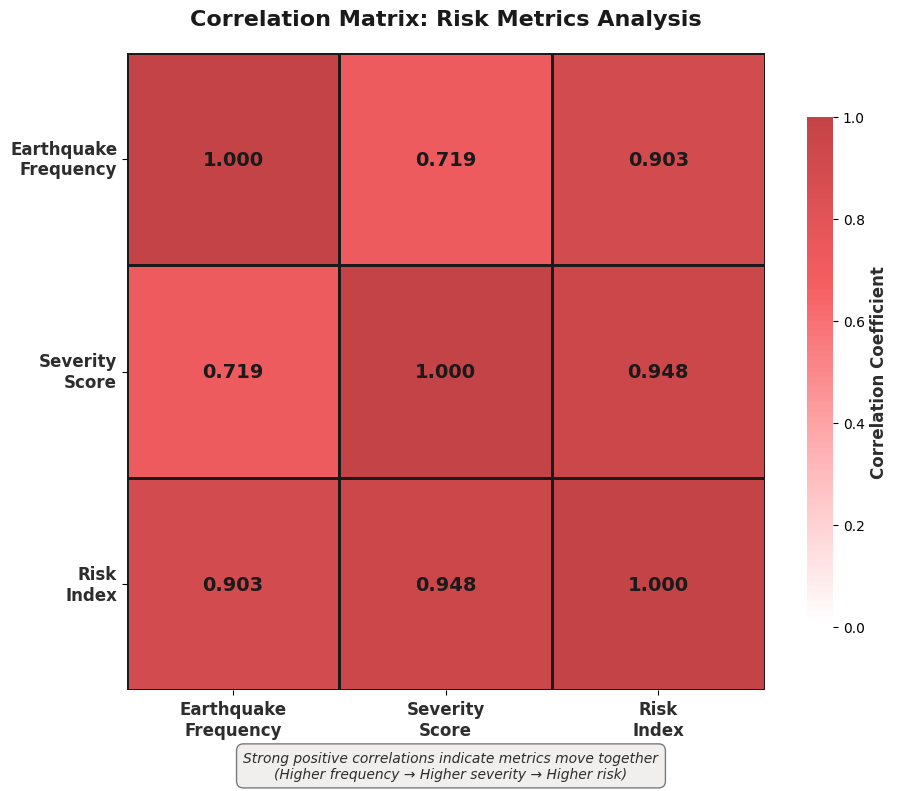

In [29]:
# ============================================
# VISUALIZATION 5: Metric Correlation Heatmap
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.functions import col

# Get the risk data as pandas
risk_pd = risk_df.toPandas()

# Select numerical columns for correlation
metrics = risk_pd[['quake_count', 'severity_score', 'risk_index']]

# Calculate correlation matrix
corr_matrix = metrics.corr()

# Create figure
fig, ax = plt.subplots(figsize=(10, 8), facecolor='white')

# Create custom colormap (white to coral red)
from matplotlib.colors import LinearSegmentedColormap
colors_list = ['white', '#FFB3B5', COLOR_PRIMARY, '#C44346']
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom_red', colors_list, N=n_bins)

# Create heatmap
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.3f',
            cmap=cmap,
            square=True,
            linewidths=2,
            linecolor=COLOR_DARK,
            cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.8},
            vmin=0, vmax=1,
            annot_kws={'size': 14, 'weight': 'bold', 'color': COLOR_DARK},
            ax=ax)

# Customize labels
labels = ['Earthquake\nFrequency', 'Severity\nScore', 'Risk\nIndex']
ax.set_xticklabels(labels, fontsize=12, fontweight='bold', color=COLOR_TEXT, rotation=0)
ax.set_yticklabels(labels, fontsize=12, fontweight='bold', color=COLOR_TEXT, rotation=0)

# Title
ax.set_title('Correlation Matrix: Risk Metrics Analysis',
             fontsize=16, fontweight='bold', color=COLOR_DARK, pad=20)

# Colorbar styling
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=10)
cbar.set_label('Correlation Coefficient', fontsize=12, fontweight='bold', color=COLOR_TEXT)

# Add interpretation text
fig.text(0.5, 0.02, 
         'Strong positive correlations indicate metrics move together\n(Higher frequency → Higher severity → Higher risk)',
         ha='center', fontsize=10, color=COLOR_TEXT, style='italic',
         bbox=dict(boxstyle='round,pad=0.5', facecolor=COLOR_SECONDARY, alpha=0.5))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()